In [25]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
import copy
import math


In [17]:
# Simulation Parameters                                                                                                         # Parameters structured in this way: []
dx = 0.01                                                                                                              # grid size
T_dur = 2.                                                                                                              # [s] Duration of simulation
dt = 0.005                                                                                                              # [s] Time-step.
setting_list = [['linear_xt', 'linear_xt', 'constant', 'point_source_center'], ['linear_xt', 'linear_xt', 'collapsing_linear', 'point_source_center'], ['linear_xt', 'linear_xt', 'collapsing_exponential', 'point_source_center'], ['linear_xt', 'linear_xt', 'constant', 'point_source_center'], ['linear_xt', 'linear_xt', 'constant', 'point_source_center'], ['linear_xt', 'linear_xt', 'constant', 'point_source_center']]     #Define various setting specs for each tasks: [mu_xt, sigma_xt, bound, initial pdf]

######### drift mu and coherence
########
mu_0 = 1.*13.97531121                                                                                                   # Constant component of drift rate mu.
coh_list = np.array([0.0,3.2,6.4,12.8,25.6,51.2])                                                                       # [%] For Duration Paradigm and in general
mu_0_list = [mu_0*0.01*coh_temp for coh_temp in coh_list]                                                               # List of mu_0, to be looped through for tasks.
param_mu_x_OUpos = 6.99053975                                                                                           # Note that this value largely depends on the model used...
param_mu_x_OUneg = -7.73123206                                                                                          # Note that this value largely depends on the model used.... NOTE that this is the regime where control is optimal over OU+-, and OU+- are significantly different.
param_mu_t = 0.                                                                                                         # Parameter for t_dependence of mu. Add more if 1 param is not sufficient...

# ############Sigma = Noise
sigma_0       = 1.*1.29705615                                                                                           # Constant component of noise sigma.
param_sigma_x = 0.5                                                                                                     # Parameter for x_dependence of sigma. Add more if 1 param is not sufficient...
param_sigma_t = 0.5                                                                                                     # Parameter for t_dependence of sigma. Add more if 1 param is not sufficient...

# B = Boundssss
B = 1.                                                                                                                  # Boundary. Assumed to be 1
param_B_t = 1.                                                                                                          # Parameter for t_dependence of B (no x-dep I sps?). Add more if 1 param is not sufficient...


# Initialization: declare arrays for usage and storage.
x_list = np.arange(-B, B+0.1*dx, dx)                                                                                    # List of x-grids (Staggered-mesh)
center_matrix_ind  = (len(x_list)-1)/2                                                                                  # index of the center of the matrix. Should be integer by design of x_list
t_list = np.arange(0., T_dur, dt)                                                                                       # t-grids


##Pre-defined list of models and the corresponding default parameters
#setting_list = [['linear_xt', 'linear_xt', 'constant', 'point_source_center'], ['linear_xt', 'linear_xt', 'collapsing_linear', 'point_source_center'], ['linear_xt', 'linear_xt', 'collapsing_exponential', 'point_source_center'], ['linear_xt', 'linear_xt', 'constant', 'point_source_center'], ['linear_xt', 'linear_xt', 'constant', 'point_source_center'], ['linear_xt', 'linear_xt', 'constant', 'point_source_center']]     #Define various setting specs for each tasks: [mu_xt, sigma_xt, bound, initial pdf]
task_list = ['Fixed_Duration', 'PsychoPhysical_Kernel', 'Duration_Paradigm', 'Pulse_Paradigm']                          # Define various setting specs for each tasks...
task_params_list = [[], [], [0.1*mu_0, T_dur/2.], [0.1*mu_0, T_dur/2.]]                                                 # Temporary parameters to test the function. Later want to vary through them. See f_mu1_task for details.
models_list_all = [0,1,2,3,4]                                                                                           # List of models to use. See Setting_list
labels_list = ['DDM', 'CB_Lin', 'CB_Expo', 'OU+', 'OU-', 'DDM_t']                                                       # Labels for the models.
param_mu_x_list = [0., 0., 0., param_mu_x_OUpos, param_mu_x_OUneg, 0.]                                                  # List of param_mu_0 input in DDM_pdf_general. Can do the same for sigma_0 etc if needed.
param_mu_t_list = [0., 0., 0., 0., 0., param_mu_t]                                                                      # List of param_mu_0 input in DDM_pdf_general. Can do the same for sigma_0 etc if needed.
param_sigma_x_list = [0., 0., 0., 0., 0., 0.]                                                                           # List of param_mu_0 input in DDM_pdf_general. Can do the same for sigma_0 etc if needed.
param_sigma_t_list = [0., 0., 0., 0., 0., 0.]                                                                           # List of param_mu_0 input in DDM_pdf_general. Can do the same for sigma_0 etc if needed.
param_B_t_list = [0., param_B_t, param_B_t, 0., 0., param_mu_t]                                                         # List of param_mu_0 input in DDM_pdf_general. Can do the same for sigma_0 etc if needed.
color_list  = ['r', 'm', 'orange', 'g', 'b', 'k']                                                                       #Colors for figures. TEMP: Want r/g/b for DDM/OU+/OU-


0.27026965669880326
0.8229247000034587


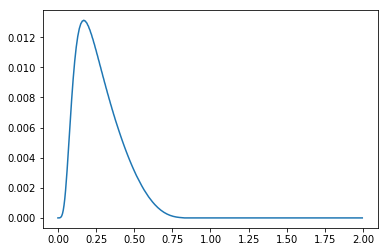

In [30]:
####################################RUN THIS CELL######################################
########################################################################################################################

def data_mod(mod_index = 1, coh_index = 3):
    '''
    mod_index: index that determines the DDM model (look at labels_list in parameters)
    for linear collapsing bounds linear
    coh_index: index that specifies the value of coherence 12.8 (look at coh_list)
    '''
    mu_coh = mu_0_list[coh_index] # drift as a function of coherence
    Prob_list_corr_temp, Prob_list_err_temp, tlist = DDM_pdf_all([mu_coh, param_mu_x_list[mod_index], param_mu_t_list[mod_index], sigma_0, param_sigma_x_list[mod_index], param_sigma_t_list[mod_index], B, param_B_t_list[mod_index]], mod_index, 0)                               # Collapsing bounds
    return Prob_list_corr_temp, Prob_list_err_temp, tlist
def data_RT(P,t):
    mean_RT = np.sum(P*t) / np.sum(P) 
    p_corr_fraction = np.sum(P)
    return mean_RT, p_corr_fraction
def plot_RTcorrect():
    Pcorr, Perr, t = data_mod()
    plt.plot(t,Pcorr)
    mean, p_fraction = data_RT(Pcorr,t)
    print(mean)
    print(p_fraction)
plot_RTcorrect()


In [23]:
#####This is the main function
def DDM_pdf_all(params, setting_index, task_index=0):
    '''
    Now assume f_mu, f_sigma, f_Bound are callable functions
    '''
    ### Initialization
    mu_0_temp          = params[0]                                                                                      # Constant component of drift rate mu.
    param_mu_x_temp    = params[1]                                                                                      # Parameter for x_dependence of mu. Add more if 1 param is not sufficient...
    param_mu_t_temp    = params[2]                                                                                      # Parameter for t_dependence of mu. Add more if 1 param is not sufficient...
    sigma_0_temp       = params[3]                                                                                      # Constant component of noise sigma.
    param_sigma_x_temp = params[4]                                                                                      # Parameter for t_dependence of sigma. Add more if 1 param is not sufficient...
    param_sigma_t_temp = params[5]                                                                                      # Parameter for t_dependence of sigma. Add more if 1 param is not sufficient...
    B_0_temp           = params[6]                                                                                      # Constant component of drift rate mu.
    param_B_t_temp     = params[7]                                                                                      # Parameter for t_dependence of B (no x-dep I sps?). Add more if 1 param is not sufficient...
    ## Simulation Settings
    settings = setting_list[setting_index]                                                                              # Define the condition for mu, sigma, and B, for x&t dependences.
    f_mu_setting = settings[0]                                                                                          # Declare the type of DDM model regarding mu. Need to modify f_mu_matrix and f_mu_flux.
    f_sigma_setting = settings[1]                                                                                       # Declare the type of DDM model regarding sigma. Need to modify f_sigma_matrix and f_sigma_flux.
    f_bound_setting = settings[2]                                                                                       # Declare the type of DDM model regarding boundaries. Specify on f_bound_t.
    f_IC_setting = settings[3]                                                                                          # Declare the type of Initial Condition. Specify on f_initial_condition
    ### Initialization: Lists
    t_list_temp = t_list
    pdf_list_curr = f_initial_condition(f_IC_setting, x_list)                                                           # Initial condition
    pdf_list_prev = np.zeros((len(x_list)))                                                                             # Pdf at the previous step
    Prob_list_corr = np.zeros(len(t_list_temp))                                                                         # Probability flux to correct choice
    Prob_list_err = np.zeros(len(t_list_temp))                                                                          # Probability flux to erred choice
    # traj_mean_pos = np.zeros(len(t_list_temp))                                                                          # Mean position of distribution
    ### Task specific
    param_task=0                                                                                                        # 0 if no extra active tasks/regimes/paradigms, else modify f_mu1_task.
    if len(params)>=9:                                                                                                  # Probably want to optimize...
        param_task = params[8]
    task_temp = task_list[task_index]
    if task_temp == 'Duration_Paradigm':
        param_task = [params[8], mu_0_temp]
    ##### Looping through time and updating the pdf.
    for i_t in range(len(t_list_temp)-1):
        pdf_list_prev = copy.copy(pdf_list_curr)                                                                        # Update Previous state. To be frank pdf_list_prev could be removed for max efficiency. Leave it just in case.
        mu_1_temp = f_mu1_task(t_list_temp[i_t], task_temp, param_task)                                                 # Perturbation to mu due to various tasks specified. Trivial if param_task=0
        mu_temp = mu_0_temp + mu_1_temp                                                                                 # Actual mu=drift to be used.
        if sum(pdf_list_curr[:])>0.0001:                                                                                # For efficiency only do diffusion if there's at least some densities remaining in the channel.
                    ### Explicit form for illustration. We actually use the implicit method instead.
                    # pdf_list[:,i_t+1] = pdf_list[:,i_t] + dt*( -deriv_first(f_mu(mu, x_list, t_list_temp[i_t], f_mu_setting, param_mu) * pdf_list[:,i_t] , dx) + deriv_second(0.5*f_sigma(sigma, x_list, t_list_temp[i_t], f_sigma_setting, param_sigma)**2 * pdf_list[:,i_t] , dx))
                    # pdf_list[:,i_t+1] = pdf_list[:,i_t] + dt*( -deriv_first(f_mu(mu, x_list, t_list_temp[i_t], f_mu_setting, param_mu), dx)*pdf_list[:,i_t] -deriv_first(pdf_list[:,i_t], dx)*f_mu(mu, x_list, t_list_temp[i_t], f_mu_setting, param_mu)  + deriv_second(0.5*f_sigma(sigma, x_list, t_list_temp[i_t], f_sigma_setting, param_sigma)**2 * pdf_list[:,i_t] , dx))
            ## Define the boundaries at current time.
            bound_temp = f_bound_t(B_0_temp, param_B_t_temp, t_list_temp[i_t], f_bound_setting)                         # Boundary at current time-step. Can generalize to assymetric bounds
            bound_shift = B_0_temp - bound_temp                                                                         # pre-define. Assumed bound_temp < B_0_temp.
            # Note that we linearly approximate the bound by the two surrounding grids sandwiching it.
            index_temp_inner = int(math.ceil(bound_shift/dx))                                                           # Index for the inner bound (smaller matrix)
            index_temp_outer = int(bound_shift/dx)                                                                      # Index for the outer bound (larger matrix)
            weight_inner    = (bound_shift - index_temp_outer*dx)/dx                                                    # The weight of the upper bound matrix, approximated linearly. 0 when bound exactly at grids.
            weight_outer    =  1. - weight_inner                                                                        # The weight of the lower bound matrix, approximated linearly.

            ## Define the diffusion matrix for implicit method
            x_list_temp = x_list[index_temp_outer:len(x_list)-index_temp_outer]                                         # List of x-positions still within bounds.
            mu_xt_temp = mu_xt_form(mu_temp, param_mu_x_temp, param_mu_t_temp, x_list_temp, t_list_temp[i_t], f_mu_setting)
            sigma_xt_temp = sigma_xt_form(sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, x_list_temp, t_list_temp[i_t], f_sigma_setting)
            matrix_diffusion = np.diag(np.ones(len(x_list_temp))) + f_mu_matrix(mu_xt_temp) + f_sigma_matrix(sigma_xt_temp)       #Diffusion Matrix for Implicit Method. Here defined as Outer Matrix, and inder matrix is either trivial or an extracted submatrix.
            ### Compute Probability density functions (pdf)
            pdf_list_temp_outer = np.linalg.solve(matrix_diffusion  , pdf_list_prev[index_temp_outer:len(x_list)-index_temp_outer])                                                     # Probability density function for outer matrix. Is np.linalg.solve_banded useful?
            if index_temp_inner == index_temp_outer:
                pdf_list_temp_inner = copy.copy(pdf_list_temp_outer)                                                                                                                    # When bound is exactly at a grid, use the most efficient method.
            else:
                pdf_list_temp_inner = np.linalg.solve(matrix_diffusion[1:-1, 1:-1], pdf_list_prev[index_temp_inner:len(x_list)-index_temp_inner])                                       # Probability density function for inner matrix. Is np.linalg.solve_banded useful?
            Prob_list_err[i_t+1]  += weight_outer*np.sum(pdf_list_prev[:index_temp_outer])               + weight_inner*np.sum(pdf_list_prev[:index_temp_inner])                        # Pdfs out of bound is considered decisions made.
            Prob_list_corr[i_t+1] += weight_outer*np.sum(pdf_list_prev[len(x_list)-index_temp_outer:]) + weight_inner*np.sum(pdf_list_prev[len(x_list)-index_temp_inner:])              # Pdfs out of bound is considered decisions made.
            pdf_list_curr = np.zeros((len(x_list)))                                                                     # Reconstruct current proability density function, adding outer and inner contribution to it.
            pdf_list_curr[index_temp_outer:len(x_list)-index_temp_outer] += weight_outer*pdf_list_temp_outer
            pdf_list_curr[index_temp_inner:len(x_list)-index_temp_inner] += weight_inner*pdf_list_temp_inner

        else:
            break       #break if the remaining densities are too small....

        ### Increase current, transient probability of crossing either bounds, as flux
        Prob_list_corr[i_t+1] += weight_outer*pdf_list_temp_outer[-1]* ( f_mu_flux(len(x_list)-1-index_temp_outer, mu_temp, param_mu_x_temp, param_mu_t_temp, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(len(x_list)-1-index_temp_outer, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, t_list_temp[i_t], f_sigma_setting)) \
                              +  weight_inner*pdf_list_temp_inner[-1]* ( f_mu_flux(len(x_list)-1-index_temp_inner, mu_temp, param_mu_x_temp, param_mu_t_temp, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(len(x_list)-1-index_temp_inner, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, t_list_temp[i_t], f_sigma_setting))
        Prob_list_err[i_t+1]  += weight_outer*pdf_list_temp_outer[ 0]* ( f_mu_flux(              index_temp_outer, mu_temp, param_mu_x_temp, param_mu_t_temp, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(              index_temp_outer, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, t_list_temp[i_t], f_sigma_setting)) \
                              +  weight_inner*pdf_list_temp_inner[ 0]* ( f_mu_flux(              index_temp_inner, mu_temp, param_mu_x_temp, param_mu_t_temp, t_list_temp[i_t], f_mu_setting) + f_sigma_flux(              index_temp_inner, sigma_0_temp, param_sigma_x_temp, param_sigma_t_temp, t_list_temp[i_t], f_sigma_setting))
        if bound_temp < dx:                                                                                             # Renormalize when the channel size has <1 grid, although all hell breaks loose in this regime.
            Prob_list_corr[i_t+1] *= (1+ (1-bound_temp/dx))
            Prob_list_err[i_t+1]  *= (1+ (1-bound_temp/dx))
        # traj_mean_pos[i_t+1] = np.sum(Prob_list_corr)*1. + np.sum(Prob_list_err[:])*-1. + np.sum(pdf_list[:,i_t+1]*x_list)        # To record the mean position.

    return Prob_list_corr, Prob_list_err, t_list    

In [20]:
############ Helper functions for DDM_pdf_all
## Initial Conditions
def f_initial_condition(f_IC_setting, x):                                                                               # Returns the pdf distribution at time 0 of the simulation
        ## Reminder: The general definition is (mu*p)_(x_{n+1},t_{m+1}) - (mu*p)_(x_{n-1},t_{m+1})... So choose mu(x,t) that is at the same x,t with p(x,t) (probability distribution function). Hence we use x_list[1:]/[:-1] respectively for the +/-1 off-diagonal.
    pdf_list_IC = np.zeros((len(x)))
    if f_IC_setting == 'point_source_center':
        pdf_list_IC[int((len(x)-1)/2)] = 1.                                                                             # Initial condition at x=0, center of the channel.
    elif f_IC_setting == 'uniform':                                                                                     # Weird dependence for testing. Remove at will.
        pdf_list_IC = 1/(len(x))*np.ones((len(x)))
    # Add f_mu_setting definitions as needed...
    else:
        print('Wrong/unspecified f_mu_setting for f_mu_matrix function')
    return pdf_list_IC


## Mu and Sigma on Diffusion Matrix
def mu_xt_form(mu_temp, param_mu_x_temp, param_mu_t_temp, x, t, f_mu_setting):
    if f_mu_setting == 'linear_xt':                                                                                     # If dependence of mu on x & t is at most linear (or constant):
        return (mu_temp + param_mu_x_temp*x + param_mu_t_temp*t)
    
    # Add f_mu_setting definitions as needed...
    else:
        print('Wrong/unspecified f_mu_setting')

def sigma_xt_form(sigma_temp, param_sigma_x_temp, param_sigma_t_temp, x, t, f_sigma_setting):
    if f_sigma_setting == 'linear_xt':                                                                                     # If dependence of mu on x & t is at most linear (or constant):
        return (sigma_temp+ param_sigma_x_temp*x + param_sigma_t_temp*t)
    
    else:
        print('Wrong/unspecified f_sigma_setting')

### Diffusion matrix terms due to different parameters (mu, sigma, bound)
def f_mu_matrix(mu_xt_temp):                                         # Diffusion Matrix containing drift=mu related terms
    ## Reminder: The general definition is (mu*p)_(x_{n+1},t_{m+1}) - (mu*p)_(x_{n-1},t_{m+1})... So choose mu(x,t) that is at the same x,t with p(x,t) (probability distribution function). Hence we use x_list[1:]/[:-1] respectively for the +/-1 off-diagonal.
    return np.diag( 0.5*dt/dx *(mu_xt_temp[1:]),1) + np.diag( -0.5*dt/dx *(mu_xt_temp[:-1]),-1)

def f_sigma_matrix(sigma_xt_temp):                          # Diffusion Matrix containing noise=sigma related terms
    # Refer to f_mu_matrix. Same idea.
    return np.diag(((sigma_xt_temp)**2*dt/dx**2))   -   np.diag(0.5*(sigma_xt_temp[1:])**2*dt/dx**2,1)   -   np.diag(0.5*(sigma_xt_temp[:-1])**2*dt/dx**2,-1)

## Bounds
## Second effect of Collapsing Bounds: Collapsing Center: Positive and Negative states are closer to each other over time.
def f_bound_t(bound_temp, param_B, t, f_bound_setting):
    if f_bound_setting == 'constant':
        return bound_temp
    elif f_bound_setting == 'collapsing_linear':
        return max(bound_temp - param_B*t, 0.)
    elif f_bound_setting == 'collapsing_exponential':
        return bound_temp*np.exp(-param_B*t)
    # Add f_bound_setting definitions as needed...
    else:
        print('Wrong/unspecified f_bound_setting')
    ###And so on...


### Flux
### Amount of flux from bound/end points to correct and erred probabilities, due to different parameters (mu, sigma, bound)
# f_mu_setting = 'constant'
def f_mu_flux(index_bound, mu_temp, param_mu_x_temp, param_mu_t_temp, t, f_mu_setting):                              # Diffusion Matrix containing drift=mu related terms
    ## Reminder: The general definition is (mu*p)_(x_{n+1},t_{m+1}) - (mu*p)_(x_{n-1},t_{m+1})... So choose mu(x,t) that is at the same x,t with p(x,t) (probability distribution function). Hence we use x_list[1:]/[:-1] respectively for the +/-1 off-diagonal.
    return 0.5*dt/dx * np.sign(x_list[index_bound]) * (mu_xt_form(mu_temp, param_mu_x_temp, param_mu_t_temp, x_list[index_bound], t, f_mu_setting))

def f_sigma_flux(index_bound, sigma_temp, param_sigma_x_temp, param_sigma_t_temp, t, f_sigma_setting):               # Diffusion Matrix containing noise=sigma related terms
    ## Similar to f_mu_flux
    return 0.5*dt/dx**2 * (sigma_xt_form(sigma_temp, param_sigma_x_temp, param_sigma_t_temp, x_list[index_bound], t, f_sigma_setting))**2


## Various tasks that causes change in signals and what not, in addition to the space and time varying f_mu, f_sigma, and f_bound.
def f_mu1_task(t, task_setting, param_task): # param_task = T_dur/2.                                                                  # Define the change in drift at each time due to active perturbations, in different tasks
    if task_setting == 'Fixed_Duration':                                                                                # No task
        return 0.
    elif task_setting == 'PsychoPhysical_Kernel':                                                                       #Note that I assumed in the DDM_general fcn for the PK case, that the input of mu_0 to be 0. Else have to counter-act the term...
        return param_task[int(t/dt_mu_PK)]                                                                                                        ## Fix/Implement later
    ## For Duration/Pulse paradigms, param_task[0]= magnitude of pulse. param_task[1]= T_Dur_Duration/t_Mid_Pulse respectively
    elif task_setting == 'Duration_Paradigm':                                                                           # Vary Stimulus Duration
        T_Dur_Duration = param_task[0]                                                                                  # Duration of pulse. Variable in Duration Paradigm
        ## if stimulus starts at 0s:
        if t< T_Dur_Duration:
            return 0
        else:
            return -param_task[1]        #Remove pulse if T> T_Dur_duration
        ## if stimulus starts at T_dur/2 =1s, use this instead and put it above:
        # t_Mid_Duration = T_dur/2.                                                                                       # (Central) Onset time of pulse/duration. Arbitrary but set to constant as middle of fixed duration task.
        # if abs(t-t_Mid_Duration)< (T_Dur_Duration/2):
    elif task_setting == 'Pulse_Paradigm':                                                                              # Add brief Pulse to stimulus, with varying onset time.
        T_Dur_Pulse = 0.1                                                                                               # Duration of pulse. 0.1s in the spiking circuit case.
        t_Pulse_onset = param_task                                                                                      # (Central) Onset time of pulse/duration. Variable in Pulse Paradigm
        if (t>t_Pulse_onset) and  (t<(t_Pulse_onset+T_Dur_Pulse)):
            return mu_0*0.15                                                                                            # 0.15 based on spiking circuit simulations.
        else:
            return 0.
        ## If we define time as at the middle of pulse, use instead:
        # t_Mid_Pulse = param_task                                                                                     # (Central) Onset time of pulse/duration. Variable in Pulse Paradigm
        # if abs(t-t_Mid_Pulse)< (T_Dur_Pulse/2):
    # Add task_setting definitions as needed...
    else:
        print('Wrong/unspecified f_mu1_task task_setting')





